### Imports and Plotting Functions

In [ ]:
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.inspection import DecisionBoundaryDisplay

# Fix seed for reproducibility
np.random.seed(231)
np.set_printoptions(precision=4)

In [ ]:
def plot_decision_boundary(
    estimator,
    X,
    *,
    grid_resolution=100,
    eps=1.0,
    **kwargs,
):
    """Generates a contour plot of the estimator's prediction thresholds."""
    x0, x1 = X[:,0],X[:,1]

    x0_min, x0_max = x0.min() - eps, x0.max() + eps
    x1_min, x1_max = x1.min() - eps, x1.max() + eps

    xx0, xx1 = np.meshgrid(
        np.linspace(x0_min, x0_max, grid_resolution),
        np.linspace(x1_min, x1_max, grid_resolution),
    )

    X_grid = np.c_[xx0.ravel(), xx1.ravel()]

    response = estimator.forward(X_grid)

    display = DecisionBoundaryDisplay(
        xx0=xx0,
        xx1=xx1,
        response=response.reshape(xx0.shape),
    )
    display.plot(plot_method="contourf", **kwargs)
    return display

def visualize_dataset(x, y, title="Visualization of dataset"):
    """Generates a scatter plot of the data."""
    scatter = plt.scatter(*x.T, c=y)
    plt.title(title)
    plt.legend(handles=scatter.legend_elements()[0], labels=[0,1])
    plt.grid(visible=True, which='both')
    plt.figure(figsize=(6, 6))
    plt.show()

def visualize_weights(mlp, gradients=True):
    """Visualize the first layer weights and gradients of an MLPClassifier."""
    z = np.zeros(mlp.w1.shape)
    plt.quiver(z[0, :], z[1, :], mlp.w1[0, :], mlp.w1[1, :],
               scale=1, width=0.005, angles='xy', scale_units='xy')
    if gradients:
        plt.quiver(mlp.w1[0, :], mlp.w1[1, :], -mlp.lr * mlp.grad_w1[0, :], -mlp.lr * mlp.grad_w1[1, :],
                   scale=1, width=0.01, angles='xy', scale_units='xy', color='r')
    plt.grid(visible=True, which='both')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.show()

### Generate Example Dataset

In [ ]:
X, y = datasets.make_circles(n_samples=1000, noise=0.1, factor=0.4)
y = y[:, np.newaxis]
print(f"The data has dimensions {X.shape} and the labels have dimensions {y.shape}.")

The data has dimensions (1000, 2) and the labels have dimensions (1000, 1).


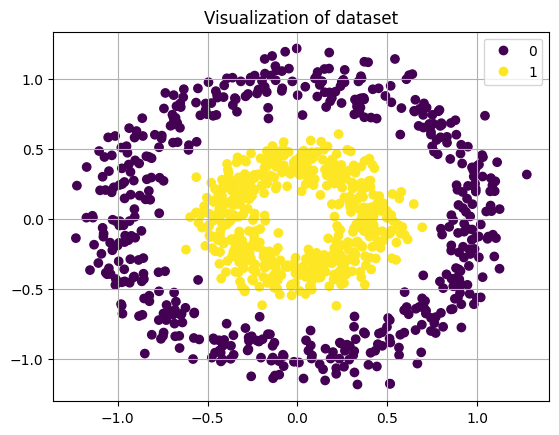

<Figure size 600x600 with 0 Axes>

In [ ]:
visualize_dataset(X, y)

### Define Activation functions and Classifier

In [ ]:
def relu(x):
    """Rectified linear activation function."""
    return np.maximum(x, 0)

def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-x))

def cross_entropy(preds, labels):
    """
    Binary cross entropy loss.

    Args:
        preds:  predicted probabiltiies
        labels: ground truth labels
    """
    # Add a small epsilon to prevent log(0)
    epsilon = 1e-9
    preds = np.clip(preds, epsilon, 1 - epsilon)
    return -np.mean(labels * np.log(preds) + (1 - labels) * np.log(1 - preds))

In [ ]:
class MLPClassifier():
    def __init__(self, lr=1e-2, in_dim=2, out_dim=1, h_dim=3):
        """
        Defines the learning rate and initializes the weight matrices
        for a simple multilayer perceptron.

        Args:
            lr:      learning rate
            in_dim:  input dimension
            out_dim: output dimension
            h_dim:   hidden dimension
        """
        self.lr = lr

        # Randomly initialize weights from a Gaussian distribution
        self.w1 = np.random.randn(in_dim, h_dim) * np.sqrt(2 / in_dim)
        self.w2 = np.random.randn(h_dim, out_dim) * np.sqrt(2 / h_dim)
        self.b = np.zeros(out_dim) + 0.1

    def forward(self, x):
        """
        Forward pass of the MLP.

        Args:
            x: input data with shape (dataset_size, in_dim)

        Returns:
            y_pred: predicted probabilities of being in class 1
        """

        # Save inputs for the gradient computation
        self.x = x

        # Save ReLU output for gradient computation
        self.h = relu(self.x @ self.w1)

        # Save for viewing purposes (not used in backward)
        self.z = self.h @ self.w2 + self.b

        y_pred = sigmoid(self.z)
        return y_pred

    def backward(self, y_pred, grad_y_pred):
        """
        Backwards pass of the MLP.

        Args:
            y_pred:      predicted probabilities of being in class 1
            grad_y_pred: gradient of the loss w.r.t y_pred
        """

        # TODO: Calculate the gradient using the chain rule

        # 1. Gradient of Loss w.r.t. z (pre-sigmoid activation)

        grad_z = grad_y_pred * (y_pred * (1.0 - y_pred))

        # 2. Gradient w.r.t. w2

        self.grad_w2 = self.h.T @ grad_z

        # 3. Gradient w.r.t. b

        self.grad_b = np.sum(grad_z, axis=0)

        # 4. Gradient w.r.t. h (ReLU output)

        grad_h = grad_z @ self.w2.T

        # 5. Gradient w.r.t. w1

        grad_relu_input = grad_h * (self.h > 0)


        self.grad_w1 = self.x.T @ grad_relu_input

    def update(self):
        """
        Update weights with gradients.
        """
        self.w1 -= self.lr * self.grad_w1
        self.w2 -= self.lr * self.grad_w2
        self.b  -= self.lr * self.grad_b

### Train MLP classifier

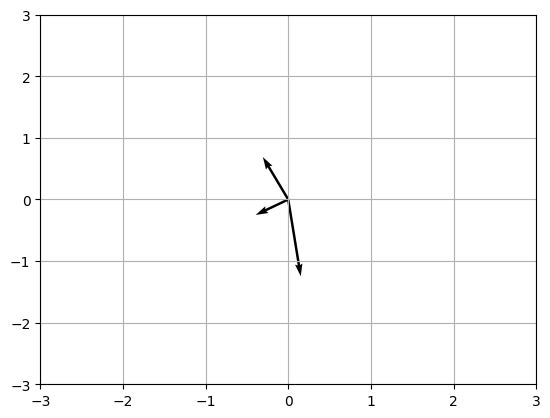

In [ ]:
mlp = MLPClassifier(lr=5e-3, h_dim=3)
loss_history, loss = [np.inf], np.inf
visualize_weights(mlp, gradients=False)

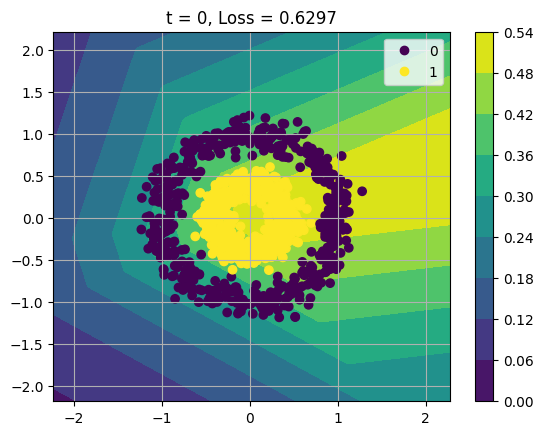

<Figure size 600x600 with 0 Axes>

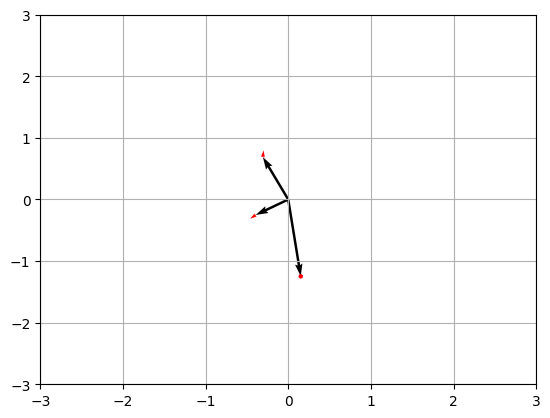

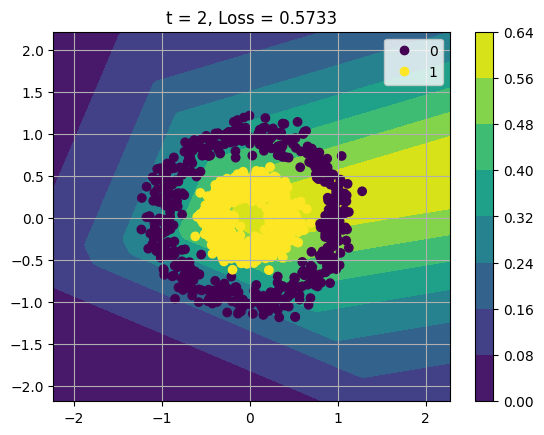

<Figure size 600x600 with 0 Axes>

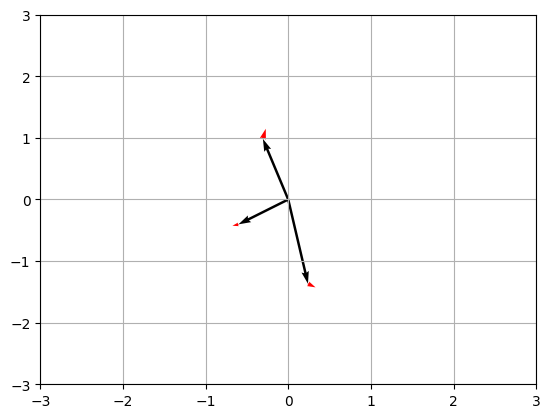

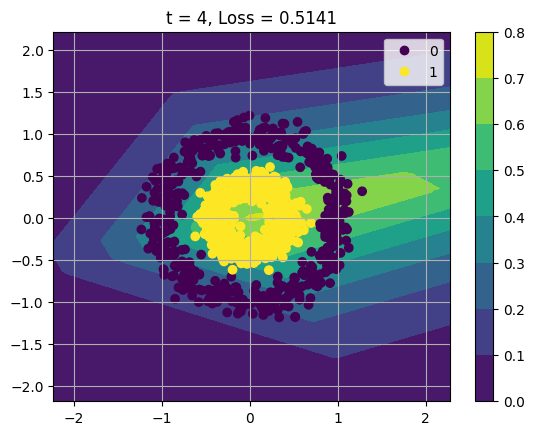

<Figure size 600x600 with 0 Axes>

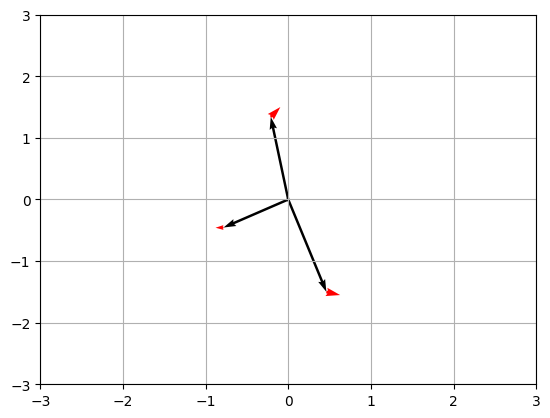

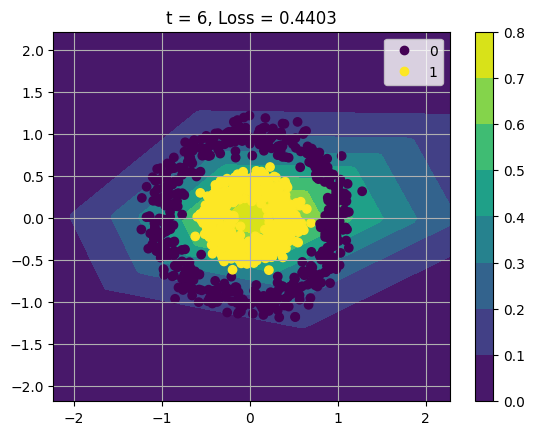

<Figure size 600x600 with 0 Axes>

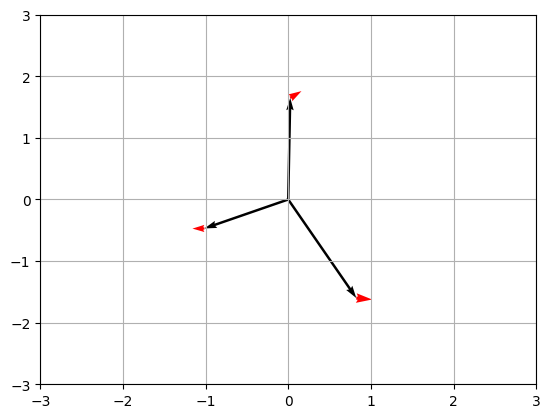

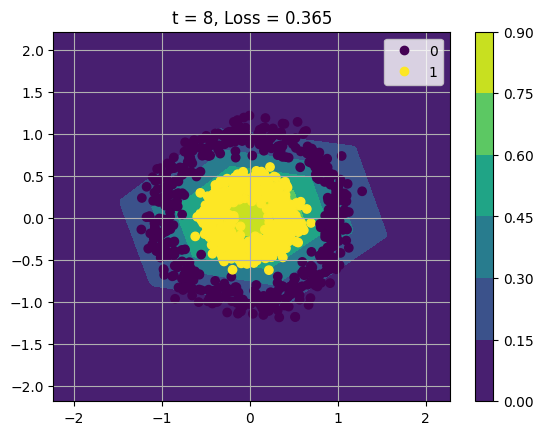

<Figure size 600x600 with 0 Axes>

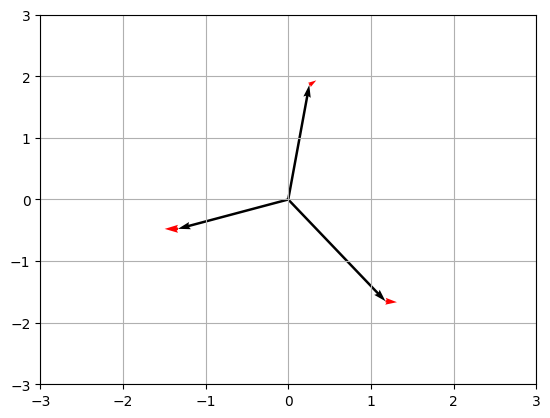

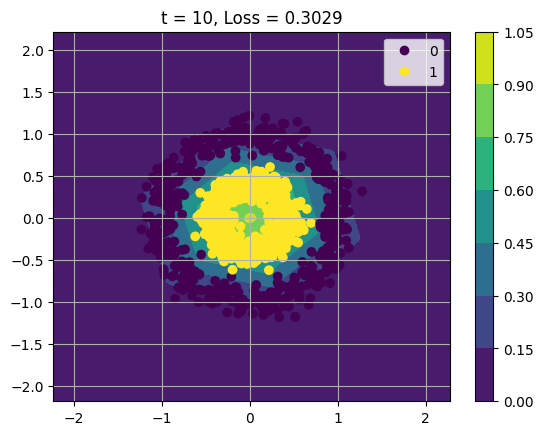

<Figure size 600x600 with 0 Axes>

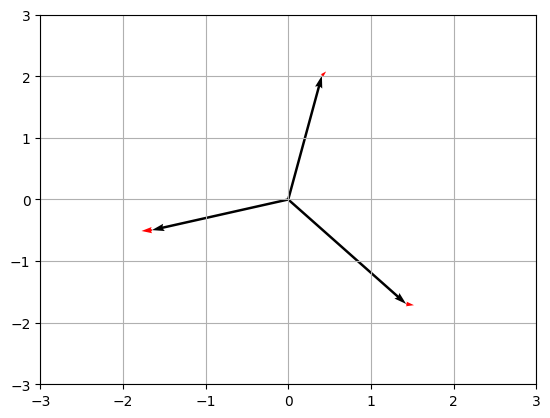

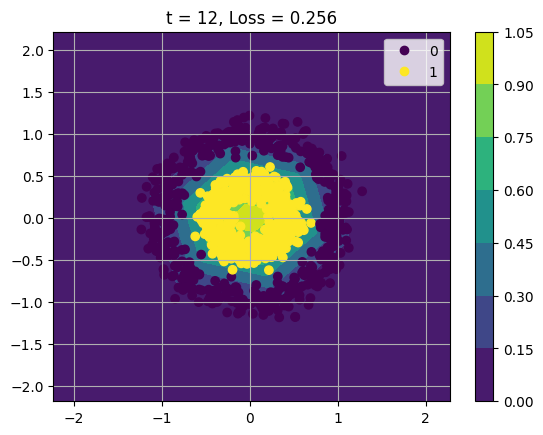

<Figure size 600x600 with 0 Axes>

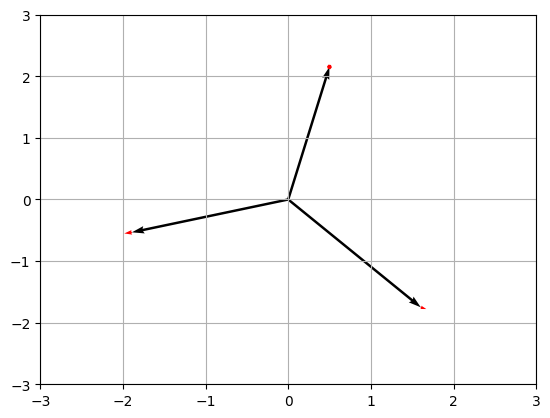

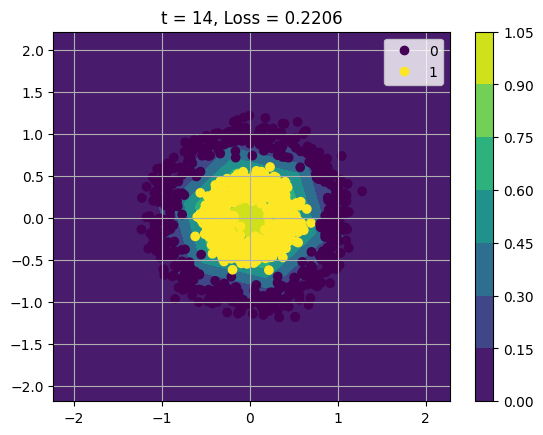

<Figure size 600x600 with 0 Axes>

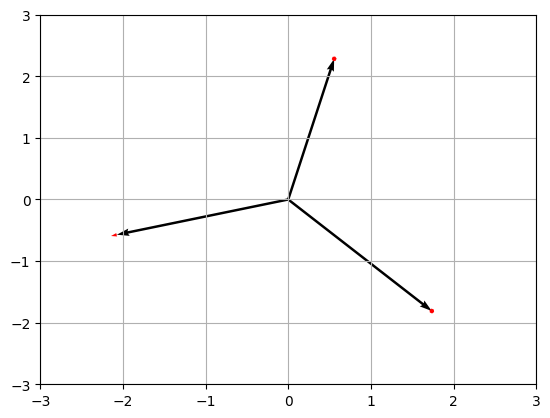

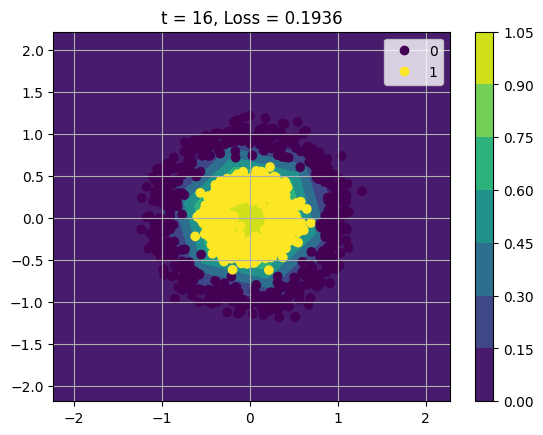

<Figure size 600x600 with 0 Axes>

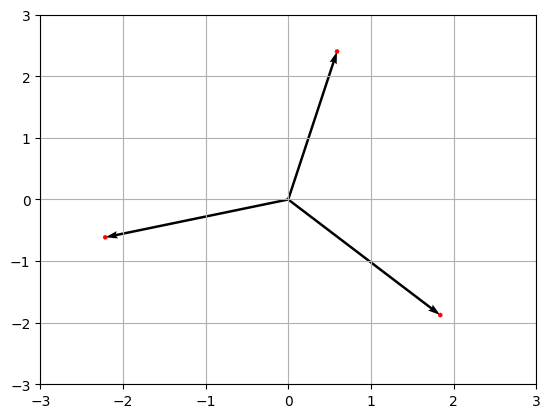

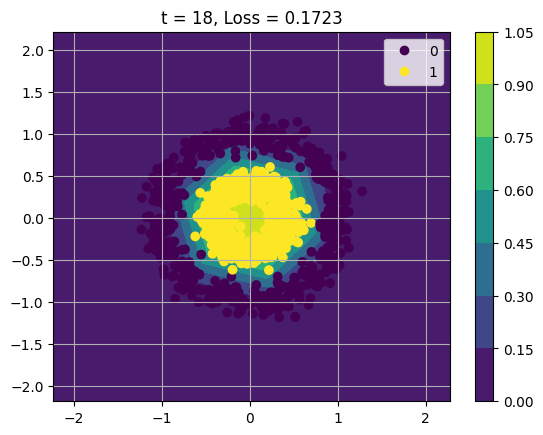

<Figure size 600x600 with 0 Axes>

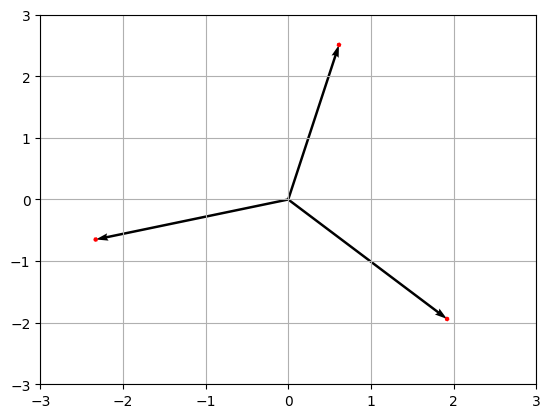

In [ ]:
# Increased epochs for better convergence
epochs = 20
for t in range(epochs):

    # === TODO ===

    # 1. Predict on data (forward pass)
    y_pred = mlp.forward(X)

    # 2. Calculate the loss
    loss = cross_entropy(y_pred, y)

    # Store the loss for visualization purposes
    loss_history.append(loss)

    # 3. Calculate loss gradient and backpropogate errors (backwards pass)


    grad_y_pred= -(y / y_pred - (1 - y) / (1 - y_pred))

    # Now, performimg the backward pass
    mlp.backward(y_pred, grad_y_pred)

    # === END TODO ===

    # Visualize classifier
    if t % (epochs // 10) == 0:
        display = plot_decision_boundary(mlp, X)
        plt.colorbar(display.ax_.collections[0])
        visualize_dataset(X, y, title=f"t = {t}, Loss = {round(loss, 4)}")
        visualize_weights(mlp)

    # 4. Update the weights
    mlp.update()


### Plot the loss curve

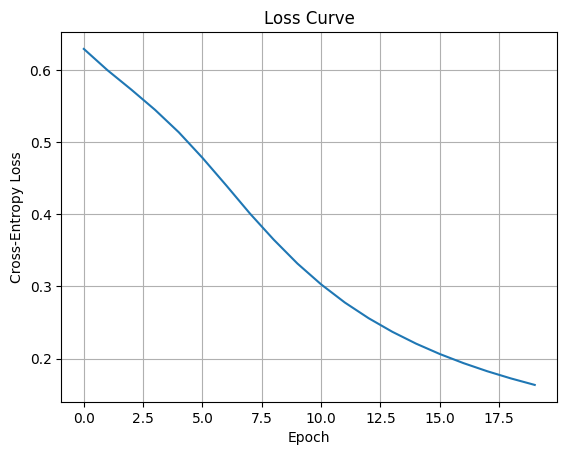

In [ ]:
# TODO
# Plot the loss history, skipping the initial 'np.inf'
plt.plot(loss_history[1:])
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.grid(True)
plt.show()

### Compute the accuracy

In [ ]:
# TODO
# 1. Get final predictions from the trained model
y_pred = mlp.forward(X)

# 2. Convert probabilities to class labels (0 or 1)
# Use a 0.5 threshold
y_pred_class = (y_pred > 0.5).astype(int)

# 3. Compare predicted classes to true labels and calculate the mean
accuracy = np.mean(y_pred_class == y)

print(f"Final Model Accuracy: {accuracy * 100:.2f}%")

Final Model Accuracy: 99.50%
